# Autoencoder test
### In this notebook we create an Autoencoder, we train it with the MNIST image set, and then we see how the encoder encodes images, and how the decoder uses the encoder output to create new images similar to the ones in the MNIST set

In [1]:
import keras
from keras.models import Model
import numpy as np
from keras.layers import Input, Flatten, Dense, Conv2D, LeakyReLU, Reshape, Conv2DTranspose, Activation
import import_ipynb

from models.AE import Autoencoder
from utils.utils import load_model, save_model

from keras.datasets import mnist

from keras.callbacks import LambdaCallback

Using TensorFlow backend.


importing Jupyter notebook from /home/fernando/generative_learning/models/AE.ipynb
importing Jupyter notebook from /home/fernando/generative_learning/utils/utils.ipynb


### Create the autoencoder, train it (you need to uncomment the line) and save the model to disk

In [2]:
autoencoder_name = 'Autoencoder_variational'

In [3]:
autoencoder = Autoencoder(
                input_dim = (28, 28, 1),
                encoder_conv_filters = [32, 64, 64, 64],
                encoder_conv_kernel_size = [3, 3, 3, 3],
                encoder_conv_strides = [1, 2, 2, 1],
                decoder_conv_t_filters = [64, 64, 32, 1],
                decoder_conv_t_kernel_size = [3, 3, 3, 3],
                decoder_conv_t_strides = [1, 2, 2, 1],
                z_dim = 2,
                variational = True,
                r_loss_factor = 2000)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the input so it's compatible with the Keras API (input must have three dimensions)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

# Train the model
# Uncomment if you want to train it again
autoencoder_model = autoencoder.get_model()
autoencoder.fit(x_train, batch_size = 32, shuffle = True, epochs = 10, callbacks = [])
save_model(model = autoencoder_model, model_name = autoencoder_name)


Epoch 1/10
60000/60000 [==============================] - 187s 3ms/step - loss: 112.5210 - __vae_r_loss: 108.2691 - __vae_kl_loss: 4.2520
Epoch 2/10
60000/60000 [==============================] - 172s 3ms/step - loss: 97.8433 - __vae_r_loss: 92.9318 - __vae_kl_loss: 4.9115
Epoch 3/10
60000/60000 [==============================] - 194s 3ms/step - loss: 94.4154 - __vae_r_loss: 89.2086 - __vae_kl_loss: 5.2069
Epoch 4/10
60000/60000 [==============================] - 184s 3ms/step - loss: 92.5011 - __vae_r_loss: 87.1399 - __vae_kl_loss: 5.3612
Epoch 5/10
60000/60000 [==============================] - 189s 3ms/step - loss: 91.1982 - __vae_r_loss: 85.7192 - __vae_kl_loss: 5.4790
Epoch 6/10
60000/60000 [==============================] - 170s 3ms/step - loss: 90.3119 - __vae_r_loss: 84.7624 - __vae_kl_loss: 5.5495
Epoch 7/10
60000/60000 [==============================] - 145s 2ms/step - loss: 89.5378 - __vae_r_loss: 83.9374 - __vae_kl_loss: 5.6003
Epoch 8/10
60000/60000 [======================

### Load the model from disk and create a new model that covers the encoder and the decoder. Get the output of those models for the test data

The encoder will encode the data in 2 dimensions (so, for every image input, it will map it to a 2d point).
The decoder will decode points in 2 dimensions to images (it takes the output of the encoder and generates an image)

In [4]:
# load the model
model = load_model(autoencoder_name)
autoencoder.load_model(model)

#model.summary()

# Create an intermediate model that represents the encoder, and get the decoder (is an intermediate layer,
# you can see it using the summary() method in the autoencoder)
#encoder_model = Model(inputs = model.input, outputs = model.layers[10].output)
# Get the decoder (non variational)
#decoder_model = model.layers[11]
decoder_model = model.layers[13]

encoder_output = encoder_model.predict(x_test)
decoder_output = decoder_model.predict(encoder_output)

Loading /home/fernando/generative_learning/models/saved/Autoencoder_variational


### Print the encoder output

Print the output from the encoder, and see how images of numbers are mapped to 2d points. We expect to see 'clusters', where different images for the same number belong to the same cluster. We also expect the clusters to overlap for numbers which visual representations are similar (like 9 and 8, or 7 and 1).

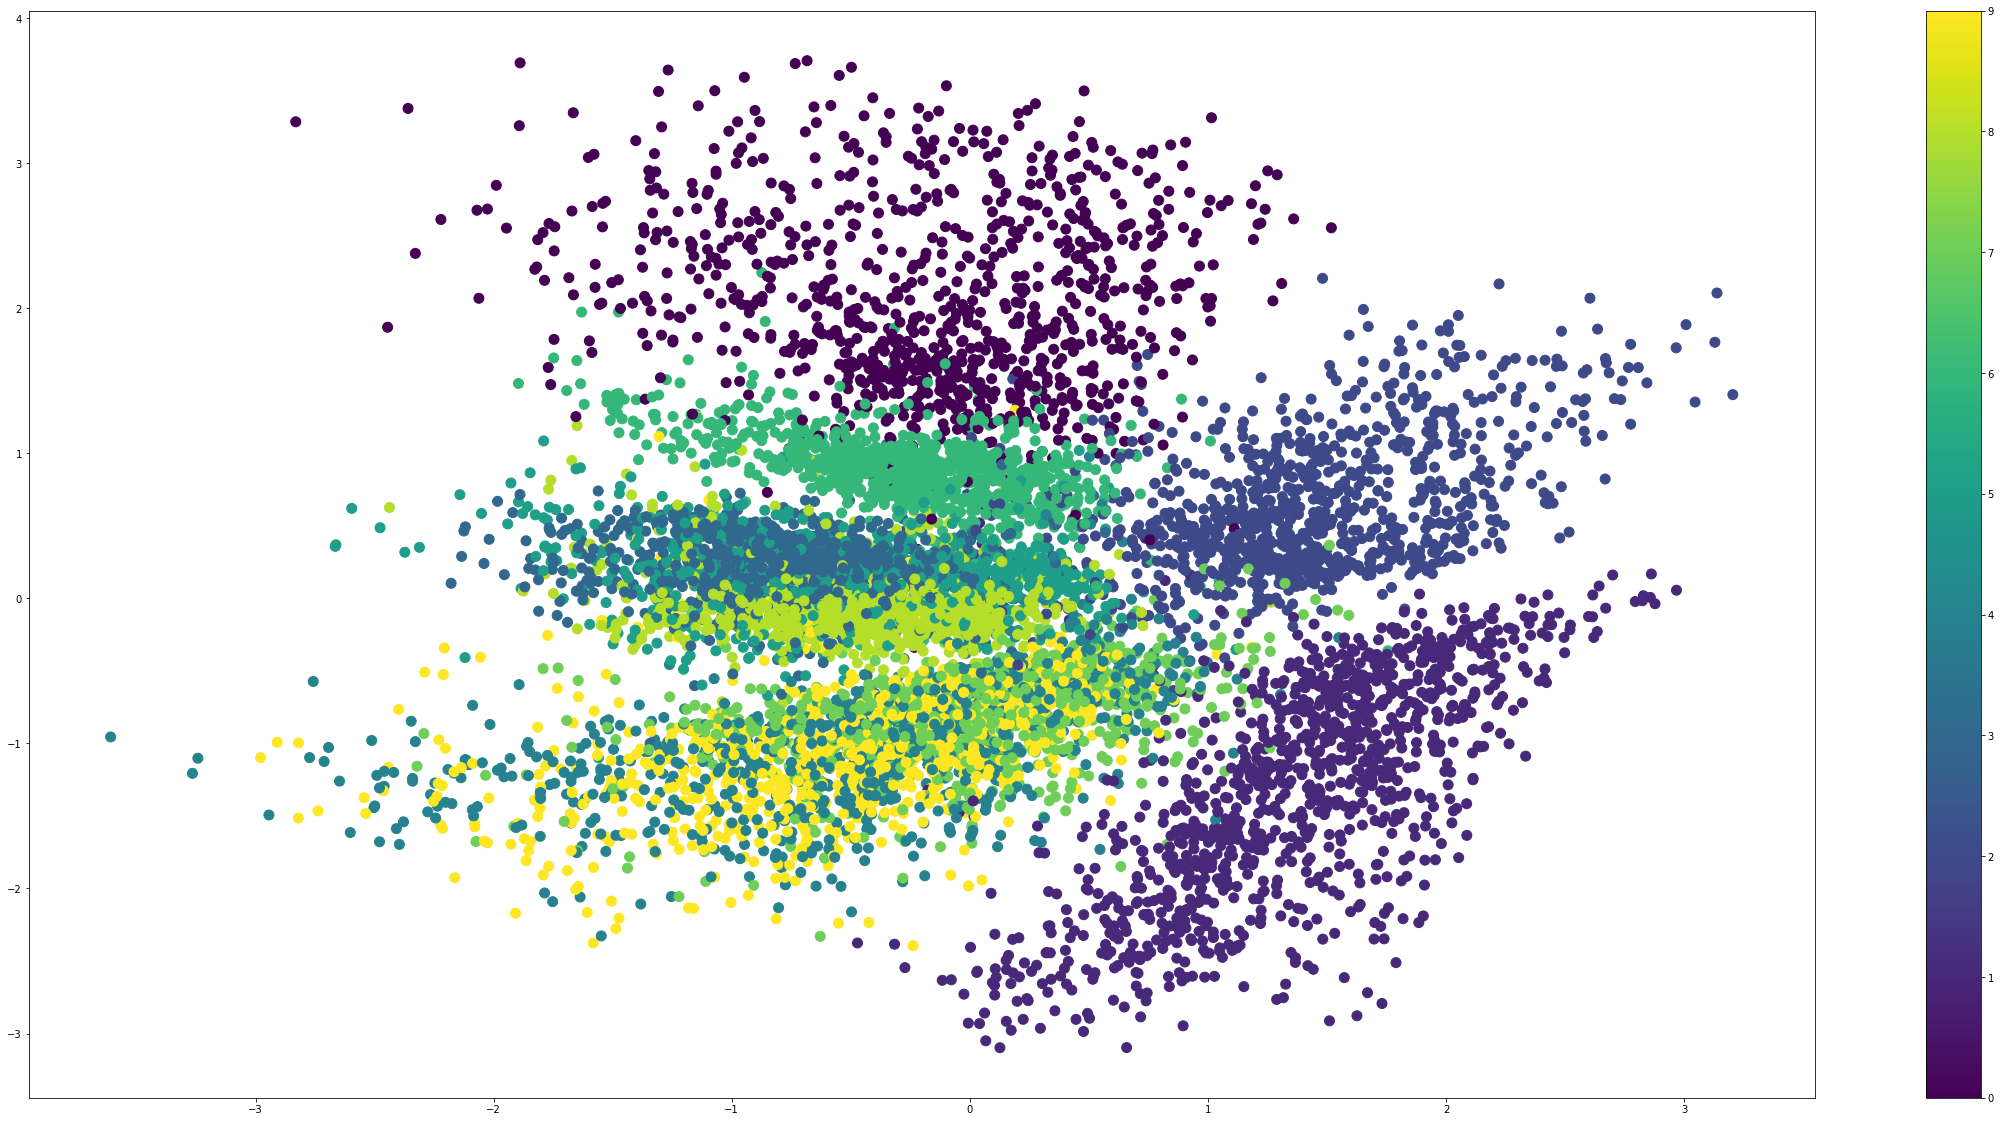

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import OrderedDict

# The output is an array of shape (1000, 2), ([[x1, y1], [x2, y2]]), here we flatten it to get: [x1, y1, x2, y2, ..]
flat_output = [item for v in encoder_output for item in v]

x_output = flat_output[::2]
y_output = flat_output[1::2]
y_test_used = y_test[:]

plt.figure(figsize=(40,20))
plt.scatter(x_output, y_output, c = y_test_used, cmap = 'viridis', s = 100)
plt.colorbar()
plt.show()

### Use the decoder to print some AI generated images
The autoencoder works the following way: the encoder learns to transform images of numbers to 2d points. The decoder learns to generate an image similar to the original, using as input the output from the encoder (the 2d points).
What we are doing here is taking some hand choosen points, and using the decoder to generate images from those points. We know what numbers we can expect to be drawn by the decoder based on the previous output (for example, we can see that the area around the point (-3, -2) corresponds to the number two, according to the colormap). 

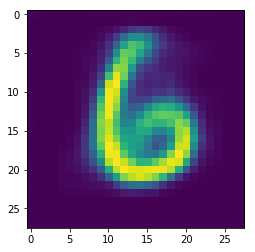

In [7]:
custom_test = np.array([[-0.5, 0.8],], np.float32)

# Shape of predicted_img is (1, 28, 28, 1)
predicted_img = decoder_model.predict(custom_test)
# Show the image
imgplot = plt.imshow(predicted_img[0,:,:,0])
plt.show()